# 1. In your program, the limiting profiles could be set directly or manually (for instance, you could play yourself the role of the Decision Maker)

In [ ]:
import pandas as pd

weights_w1 = {
    "Energy (kcal)": 4,
    "Sugars (g)": 3,
    "Saturated Fat (g)": 3,
    "Salt (g)": 3,
    "Proteins (g)": 2,
    "Fiber (g)": 2,
    "Fruits/Vegetables (%)": 1,
}

thresholds = [0.5, 0.6]

# Define limiting profiles for Nutri-Score categories (A to E)
limiting_profiles = {
    "A": {"Energy (kcal)": 335, "Sugars (g)": 5, "Saturated Fat (g)": 1, "Salt (g)": 0.1, "Proteins (g)": 8, "Fiber (g)": 10, "Fruits/Vegetables (%)": 40},
    "B": {"Energy (kcal)": 400, "Sugars (g)": 10, "Saturated Fat (g)": 2, "Salt (g)": 0.3, "Proteins (g)": 6, "Fiber (g)": 8, "Fruits/Vegetables (%)": 20},
    "C": {"Energy (kcal)": 500, "Sugars (g)": 15, "Saturated Fat (g)": 3, "Salt (g)": 0.5, "Proteins (g)": 4, "Fiber (g)": 5, "Fruits/Vegetables (%)": 10},
    "D": {"Energy (kcal)": 700, "Sugars (g)": 20, "Saturated Fat (g)": 5, "Salt (g)": 1.0, "Proteins (g)": 2, "Fiber (g)": 3, "Fruits/Vegetables (%)": 5},
    "E": {"Energy (kcal)": 900, "Sugars (g)": 30, "Saturated Fat (g)": 8, "Salt (g)": 2.0, "Proteins (g)": 0, "Fiber (g)": 0, "Fruits/Vegetables (%)": 0},
}

def transform_criteria(row):

    transformed_row = row.copy()
    for criterion in row.index:
        if criterion in ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]:  # Minimized
            transformed_row[criterion] = 10 - row[criterion]
        elif criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:  # Maximized
            transformed_row[criterion] = 2 * row[criterion]
    return transformed_row

def compute_concordance(item, profile, weights):

    transformed_item = transform_criteria(item)
    concordance = 0
    total_weight = sum(weights.values())
    for criterion, value in profile.items():
        if criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:
            # Criteria to maximize
            if transformed_item[criterion] >= value:
                concordance += weights[criterion]
        else:
            # Criteria to minimize
            if transformed_item[criterion] <= value:
                concordance += weights[criterion]
    return concordance / total_weight

def pessimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    for category, profile in sorted(profiles.items()):
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category

data = pd.read_excel("data_nutri_score.xlsx")
results = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category = pessimistic_majority_sorting(row, limiting_profiles, weights_w1, lambda_value)

        results.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category
        })
df = pd.DataFrame(results)
df

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.5,A
1,cruesly mélange de noix,A,0.6,A
2,Céréales Chocapic,A,0.5,A
3,Céréales Chocapic,A,0.6,A
4,Flocons d'avoine,A,0.5,B
...,...,...,...,...
1881,Clusters,C,0.6,A
1882,Bamboo,A,0.5,A
1883,Bamboo,A,0.6,A
1884,Müesli croccante all'avena,C,0.5,A


# 2. finding limiting profiles using quintile approach

In [ ]:
#using segmentation approach (quantile approach) to find limiting profiles:
columns_to_min = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
columns_to_max = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]

quintiles_min = data[columns_to_min].quantile([0.2, 0.4, 0.6, 0.8])
quintiles_max = data[columns_to_max].quantile([0.2, 0.4, 0.6, 0.8])

print(quintiles_min)
print(quintiles_max)

     Energy (kcal)  Sugars (g)  Saturated Fat (g)  Salt (g)
0.2          369.0    5.620000                0.6    0.0200
0.4          380.0   13.580000                1.2    0.0766
0.6          401.2   17.673333                2.0    0.2800
0.8          443.0   22.000000                3.8    0.6600
     Proteins (g)  Fiber (g)  Fruits/Vegetables (%)
0.2           8.0        5.5                 0.0000
0.4           9.0        7.0                 0.0000
0.6          10.0        8.5                 1.5875
0.8          12.0       10.0                12.9800


In [ ]:
data[columns_to_max].max().to_dict()

{'Proteins (g)': 80.0, 'Fiber (g)': 33.0, 'Fruits/Vegetables (%)': 99.796875}

In [ ]:
limiting_profiles_2 = {
    "A": {**quintiles_min.loc[0.2].to_dict(), **data[columns_to_max].max().to_dict()},  # Min Q1 + Max valeurs
    "B": {**quintiles_min.loc[0.4].to_dict(), **quintiles_max.loc[0.8].to_dict()},     # Min Q2 + Max Q4
    "C": {**quintiles_min.loc[0.6].to_dict(), **quintiles_max.loc[0.6].to_dict()},     # Min Q3 + Max Q3
    "D": {**quintiles_min.loc[0.8].to_dict(), **quintiles_max.loc[0.4].to_dict()},     # Min Q4 + Max Q2
    "E": {**data[columns_to_min].max().to_dict(), **quintiles_max.loc[0.2].to_dict()}  # Max valeurs + Min Q1
}

limiting_profiles_2

{'A': {'Energy (kcal)': 369.0,
  'Sugars (g)': 5.620000000000002,
  'Saturated Fat (g)': 0.6,
  'Salt (g)': 0.02,
  'Proteins (g)': 80.0,
  'Fiber (g)': 33.0,
  'Fruits/Vegetables (%)': 99.796875},
 'B': {'Energy (kcal)': 380.0,
  'Sugars (g)': 13.58,
  'Saturated Fat (g)': 1.2,
  'Salt (g)': 0.07660000000000002,
  'Proteins (g)': 12.0,
  'Fiber (g)': 10.0,
  'Fruits/Vegetables (%)': 12.98},
 'C': {'Energy (kcal)': 401.19999999999993,
  'Sugars (g)': 17.673333333333595,
  'Saturated Fat (g)': 2.0,
  'Salt (g)': 0.28,
  'Proteins (g)': 10.0,
  'Fiber (g)': 8.5,
  'Fruits/Vegetables (%)': 1.5874999999999995},
 'D': {'Energy (kcal)': 443.0,
  'Sugars (g)': 22.0,
  'Saturated Fat (g)': 3.8,
  'Salt (g)': 0.66,
  'Proteins (g)': 9.0,
  'Fiber (g)': 7.0,
  'Fruits/Vegetables (%)': 0.0},
 'E': {'Energy (kcal)': 601.0,
  'Sugars (g)': 48.0,
  'Saturated Fat (g)': 20.7,
  'Salt (g)': 8.4,
  'Proteins (g)': 8.0,
  'Fiber (g)': 5.5,
  'Fruits/Vegetables (%)': 0.0}}

In [ ]:
df_limit_profiles = pd.DataFrame(limiting_profiles_2)
df_limit_profiles

,A,B,C,D,E
Energy (kcal),369.000000,380.0000,401.200000,443.00,601.0
Sugars (g),5.620000,13.5800,17.673333,22.00,48.0
Saturated Fat (g),0.600000,1.2000,2.000000,3.80,20.7
Salt (g),0.020000,0.0766,0.280000,0.66,8.4
Proteins (g),80.000000,12.0000,10.000000,9.00,8.0
Fiber (g),33.000000,10.0000,8.500000,7.00,5.5
Fruits/Vegetables (%),99.796875,12.9800,1.587500,0.00,0.0


In [ ]:
data = pd.read_excel("data_nutri_score.xlsx")
results_2 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_2 = pessimistic_majority_sorting(row, limiting_profiles_2, weights_w1, lambda_value)

        results_2.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_2
        })

df_2 = pd.DataFrame(results_2)
df_2

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.5,B
1,cruesly mélange de noix,A,0.6,B
2,Céréales Chocapic,A,0.5,B
3,Céréales Chocapic,A,0.6,B
4,Flocons d'avoine,A,0.5,B
...,...,...,...,...
1881,Clusters,C,0.6,B
1882,Bamboo,A,0.5,B
1883,Bamboo,A,0.6,B
1884,Müesli croccante all'avena,C,0.5,B


# 3. compare your results with the real Nutri-Score assignments (by using, for instance, a confusion matrix).

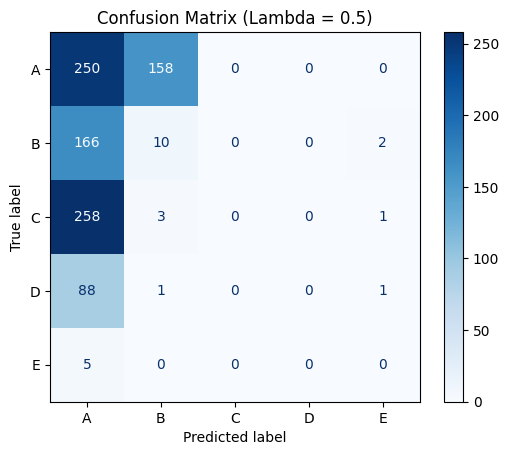

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df[df["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()


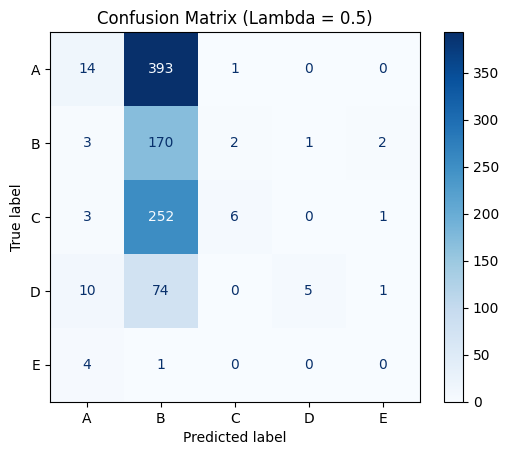

In [ ]:
subset = df_2[df_2["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()